# Machine learning on wine

**Topics:** Text analysis, linear regression, logistic regression, text analysis, classification

**Datasets**

- **wine-reviews.csv** Wine reviews scraped from https://www.winemag.com/
- **Data dictionary:** just go [here](https://www.winemag.com/buying-guide/tenuta-dellornellaia-2007-masseto-merlot-toscana/) and look at the page

## The background

You work in the **worst newsroom in the world**, and you've had a hard few weeks at work - a couple stories killed, a few scoops stolen out from under you. It's not going well.

And because things just can't get any worse: your boss shows up, carrying a huge binder. She slams it down on your desk.

"You know some machine learning stuff, right?"

You say "no," but she isn't listening. She's giving you an assignment, the _worst assignment_:

> Machine learning is the new maps. Let's get some hits!
>
> **Do some machine learning on this stuff.**

"This stuff" is wine reviews.

## A tiny, meagre bit of help

You have a dataset. It has some stuff in it:

* **Numbers:**
    - Year published
    - Alcohol percentage
    - Price
    - Score
    - Bottle size
* **Categories:**
    - Red vs white
    - Different countries
    - Importer
    - Designation
    - Taster
    - Variety
    - Winery
* **Free text:**
    - Wine description

# Cleaning up your data

Many of these pieces - the alcohol, the year produced, the bottle size, the country the wine is from - aren't in a format you can use. Convert the ones to numbers that are numbers, and extract the others from the appropriate strings.

In [1]:
#Imports
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns",100)

In [2]:
# Reading in the file
df=pd.read_csv("wine-reviews.csv")

In [3]:
# Extracting the year of the wine from wine name
df["wine_name"]=df["wine_name"].str.strip(".")
df["wine_year"]= df["wine_name"].str.extract(r"(\d\d\d\d)").astype(float)

# Extracting price
df["wine_price"]=df["price"].str.extract(r"(\d+)").astype(float)

# Converting alcohol pct to float
df["alcohol"]=df.alcohol.str.strip("%").astype(float)

# Converting bottle size to ml (some are in litres)
df["bottle_size_measure"]=df["bottle size"].str.extract(r"(\D+$)")
df["bottle_size_measure"]=df["bottle_size_measure"].str.strip()
df["bottle_size_measure"]=df["bottle_size_measure"].str.lower()
df["bottle_size_ml"]=df["bottle size"].str.extract(r"(\d+)")
df.loc[df.bottle_size_measure=="l","bottle_size_ml"]=df.bottle_size_ml*1000

# Extracting score from the rating variable
df["score"]=df["user avg rating"].str.extract(r"(\d+)")

# Extracting country
df["country"]=df["appellation"].str.extract("(\w+$)")

# Converting vartype for categorical variables

# Variety
df["variety"]=df["variety"].astype("category")
df["variety_code"]=df["variety"].cat.codes

# Category
df["category"]=df["category"].astype("category")
df["category_code"]=df["category"].cat.codes

# Importer
df["importer"]=df["importer"].astype("category")
df["importer_code"]=df["importer"].cat.codes

# Published date
df["date published"]=pd.to_datetime(df["date published"])

# Extracting published year from date as instructed in the notebook
df["year_published"]=df["date published"].dt.year

# Winery
df["winery"]=df["winery"].astype("category")
df["winery_code"]=df["winery"].cat.codes

# Designation
df["designation"]=df["designation"].astype("category")
df["designation_code"]=df["designation"].cat.codes

# Renaming variables
df=df.rename(columns={
"alcohol":"alcohol_percentage"})

In [4]:
# Dropping the columns I have replaced after cleaning above
df=df.drop(columns=["price","user avg rating","bottle size","bottle_size_measure"])

In [5]:
# Manually cleaning some wine year values.
# Going to avoid using year, as there are other errors. The numbers are not consistent, and therefore, this cannot be easily
# extracted using regex. If I had the time, I would split by space, extract all the numbers separately and screen for the year.
df.loc[18115, "wine_year"]=2014
df.loc[10689,"wine_year"]=2011

#Manually cleaning alcohol percentage
df.loc[14638,"alcohol_percentage"]=np.nan

## What might be interesting in this dataset?

Maybe start out playing around _without_ machine learning. Here are some thoughts to get you started:

* I've heard that since the 90's wine has gone through [Parkerization](https://www.estatewinebrokers.com/blog/the-parkerization-of-wine-in-the-1990s-and-beyond/), an increase in production of high-alcohol, fruity red wines thanks to the influence of wine critic Robert Parker.
* Red and white wines taste different, obviously, but people always use [goofy words to describe them](https://winefolly.com/tutorial/40-wine-descriptions/)
* Once upon a time in 1976 [California wines proved themselves against France](https://en.wikipedia.org/wiki/Judgment_of_Paris_(wine)) and France got very angry about it

#### The rolling average of alcohol content shows that the alcohol percentage of wines has decreased since the 1900s to the 2000s.

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


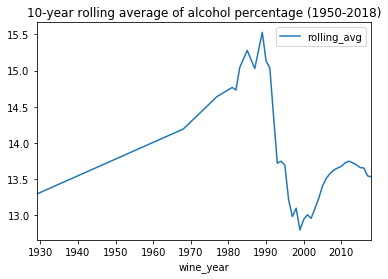

In [152]:
# Finding the mean alcohol percentage by year
averages=df[["wine_year","alcohol_percentage"]]
averages["wine_year"]=averages["wine_year"].astype(str)
averages=df.groupby(by="wine_year").alcohol_percentage.mean()
averages=averages.dropna()
averages=pd.DataFrame(averages).reset_index()

# Calculating the 10-year rolling average
rolling=averages.rolling(10, on="wine_year").alcohol_percentage.mean()
rolling=pd.DataFrame(rolling).reset_index(drop=True)

rolling=rolling.rename(columns={
    "alcohol_percentage":"rolling_avg"
})

averages=rolling.join(averages)
averages=averages.dropna()
averages.plot(x="wine_year", y="rolling_avg", title="10-year rolling average of alcohol percentage (1950-2018)")


## But machine learning?

Well, you can usually break machine learning down into a few different things. These aren't necessarily perfect ways of categorizing things, but eh, close enough.

* **Predicting a number**
    - Linear regression
    - How does a change in unemployment translate into a change in life expectancy?
* **Predicting a category** (aka classification)
    - Lots of algos options: logistic regression, random forest, etc
    - For example, predicting cuisines based on ingredients
* **Seeing what influences a numeric outcome**
    - Linear regression since the output is a number
    - For example, minority and poverty status on test scores 
* **Seeing what influences a categorical outcome**
    - Logistic regression since the output is a category
    - Race and car speed for if you get a waring vs ticket
    - Wet/dry pavement and car weight if you survive or not in a car crash)

We have numbers, we have categories, we have all sorts of stuff. **What are some ways we can mash them together and use machine learning?**

### Brainstorm some ideas

Use the categories above to try to come up with some ideas. Be sure to scroll up where I break down categories vs numbers vs text!

**I'll give you one idea for free:** if you don't have any ideas, start off by creating a classifier that determines whether a wine is white or red based on the wine's description.

#### ML exercise 1: Do wine points predict the price of wine?
##### A multi-variate regression

#### Specifications
- Dependent variable: Price
- Independent variables: Wine_points
- Control variables: Bottle size , Variety, Winery, Category, Year  (proxy for age), Alcohol percentage



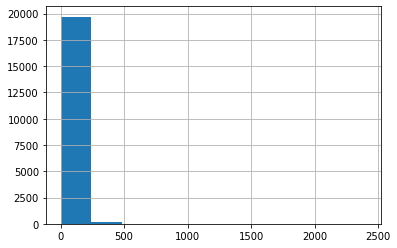

In [6]:
# First, exploring the variable distributions
df.wine_price.hist()

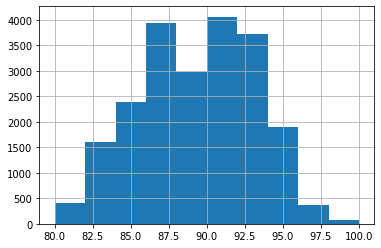

In [7]:
df.wine_points.hist()

In [8]:
# dropping the na values
df2=df.dropna(subset=["wine_points","wine_price","variety_code","category_code","wine_year","winery_code","alcohol_percentage"])

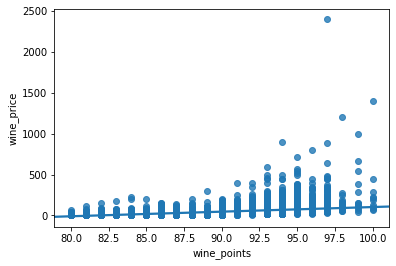

In [9]:
# Plotting a scatter plot of the dependent and independent variables

# Controlling, below should help reduce the noise

sns.regplot(data=df2,x="wine_points",y="wine_price")

In [10]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Creating the X and y variables
X=df2[["wine_points","variety_code","category_code","wine_year","winery_code","alcohol_percentage"]]
X=sm.add_constant(X)
y=df2["wine_price"]

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
model=sm.OLS(y,X)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             wine_price   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     792.1
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        16:55:32   Log-Likelihood:                -84175.
No. Observations:               16328   AIC:                         1.684e+05
Df Residuals:                   16321   BIC:                         1.684e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                900.7796    104.353      8.632      0.000     696.236    1105.323
wine_points            5.6281      0.088     63.818      0.000       5.455       5.801
variety_code          -0.0324      0.003    -11.213      0.000      -0.038      -0.027
category_code         -2.4614      0.235    -10.487      0.000      -2.921      -2.001
wine_year             -0.6725      0.052    -12.833      0.000      -0.775      -0.570
winery_code            0.0002      0.000      1.020      0.308      -0.000       0.000
alcohol_percentage     0.4584      0.208      2.199      0.028       0.050       0.867
==============================================================================
Omnibus:                    34127.379   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        332157318.765
Skew:                          17.570   Prob(JB):                         0.00
Kurtosis:                     700.848   Cond. No.                     1.56e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Results:
- The equation is y=5.6281x+900.7796.
- The slope/co-efficient is 5.6281, which means that for every point, the price of wine increases by ~ USD 6. 
- The relationship between wine's rating and its price is positive and significant at the 5% level of significance.
- The intercept is USD 900.7796, which means that the base price of wine, when the score is 0 is ~ USD 901.

#### Assessing the goodness of fit:
- The R^2 is 0.226 or 22.6%, which means that 22.6% of the variation in y can be attributed to x. This is pretty low which means
that we can do better in designing our model.
- Pearson's correlation co-efficient is 0.475.
- The root mean square error is 41.95 which means that on average, a predicted y-value is 41.95 units away from its actual value.

In [12]:
pearson=np.sqrt(0.226)
pearson

0.4753945729601885

In [13]:
predicted_y=results.predict()
residuals=results.resid

results_df=pd.DataFrame({
    "y_actual":y,
    "y_predicted":predicted_y,
    "residual":residuals
})


In [14]:
rmse=np.sqrt(results.mse_resid)
rmse

41.953441328039524

#### ML exercise 2: What predicts if a wine will be rated as a Classic?

#### Wine points scale:
- 95-100 Classic: a great wine
- 90-94 Outstanding: a wine of superior character and style
- 85-89 Very good: a wine with special qualities
- 80-84 Good: a solid, well-made wine
- 75-79 Mediocre: a drinkable wine that may have minor flaws
- 50-74 Not recommended

In [15]:
# Creating a label variable which will show if the wine has been rated as a classic (1) or not (0)
df["label"]=0
df.loc[df["wine_points"]>94, "label"]=1

In [16]:
# The distribution of classic vs non-classic wines in my dataset is not great,but I go ahead with it as classic wines, I suspect
## are rare
df.label.value_counts(normalize=True)

0    0.949802
1    0.050198
Name: label, dtype: float64

In [17]:
# Preparing my dataset for logistic regression

# Tasters: As tasters assign wine points, I am interested in finding out if they predict the points that a wine gets.
## Instead of using their names (as there are so many), I bucket them based on the number of wines they have rated. This stands
## as a proxy for experience. 

rates=pd.DataFrame(df.taster.value_counts()).reset_index()

rates=rates.rename(columns={
    "index":"name",
    "taster":"number"
})

rates.loc[rates["number"]>1000, "experience"]="high"
rates.loc[rates["number"]<200, "experience"]="low"
rates.loc[(rates["number"]<1000) & (rates["number"]>200), "experience"]="medium"

rates=rates[["name","experience"]]

df=df.merge(rates, left_on="taster", right_on="name", how="outer")


In [18]:
# Reducing the number of categories under category by coding wines other than red, white and sparkling as other
df.category=df.category.replace({
    "Rose": "Other", 
    "Dessert": "Other",
    "Port/Sherry": "Other", 
    "Fortified":"Other",
    "Sparking":"Other"
})

In [19]:
# Dropping nans:
reg_df=df[["category", "alcohol_percentage","wine_year","experience","label","variety_code","winery_code"]]
reg_df=reg_df.dropna()


In [20]:
# Hot-encoding and dropping reference variables ("Other" for category and "high" for experience)
reg_df=pd.get_dummies(data=reg_df, columns=["category","experience"]).drop(columns=["category_Other","experience_low"])

In [21]:
reg_df.sample()

,alcohol_percentage,wine_year,label,variety_code,winery_code,category_Red,category_Sparkling,category_White,experience_high,experience_medium
19684,14.5,2012.0,0,41,5,1,0,0,0,1


In [22]:
# Creating the X and y variables
X=reg_df[["alcohol_percentage","wine_year","category_Red","category_White","experience_high","experience_medium","variety_code","winery_code"]]

In [23]:
y=reg_df["label"]

In [24]:
# splitting the dataset into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42)

In [25]:
X_train.shape

(9292, 8)

In [26]:
y_train.shape

(9292,)

In [27]:
X_test.shape

(3098, 8)

In [28]:
y_test.shape

(3098,)

In [29]:
# Checking the distribution of the label in the train and test datasets
y_train.value_counts()

0    8905
1     387
Name: label, dtype: int64

In [30]:
y_test.value_counts()

0    2974
1     124
Name: label, dtype: int64

In [31]:
#Fitting in the logistic regression model into the training dataset
from sklearn.linear_model.logistic import LogisticRegression
model=LogisticRegression(C=1e9, solver="lbfgs",max_iter=4000)
results=model.fit(X_train, y_train)

In [32]:
pd.DataFrame({
    "Feature":X_train.columns,
    "Log Co-efficient":results.coef_[0],
    "Odds-ratio":np.exp(results.coef_[0])
}).sort_values(by="Log Co-efficient", ascending=False)

,Feature,Log Co-efficient,Odds-ratio
5,experience_medium,0.172526,1.188303
0,alcohol_percentage,0.037621,1.038337
7,winery_code,0.000020,1.000020
1,wine_year,-0.001178,0.998822
6,variety_code,-0.001179,0.998822
4,experience_high,-0.044614,0.956367
2,category_Red,-1.316254,0.268138
3,category_White,-1.450068,0.234554


In [33]:
# Applying the model to the test dataset
predictions=model.predict(X_test)
probabilities=model.predict_proba(X_test)

In [34]:
# Checking the model's performance
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test, predictions)

matrix=pd.DataFrame(matrix, index=["Actual_0","Actual_1"], columns=["Predicted_0", "Predicted_1"])
matrix

,Predicted_0,Predicted_1
Actual_0,2974,0
Actual_1,124,0


In [35]:
# Accuracy
print(f"The accuracy percentage is {(2974)/(2974+124)*100:.2f}%")

The accuracy percentage is 96.00%


#### Results:
- The distribution of Classic vs. non-Classic wines was skewed towards non-classic wines in the dataset, which seems to be why the model is unable to predict classic  wines in the test dataset, while it predicts 100% of the non-Classic wines correctly.
- Sensitivity/Recall is 0% and Specificity is 100%.
- Winery and variety codes should ideally be narrowed down and coded as hot-encoded, but in this case, I retain them as numeric values as there are too many in number.
- The model shows that (A) taster experience changes the odds of a wine's score. Tasters with the most experience are less likely to provide a high score (i.e., for every additional wine tasted by a taster, there is a ~4 point decrease in the outcome variable as compared to a taster with low experience. In other words, a taster with low experience is more likely to provide wine points that a taster with high experience. Tasters with medium experience however, provide 18% more points that tasters with low experience. (B) Other wines (Sparkling, Rose,etc) are more likely to be provided higher points than Red and White wines.

#### Trying the same with a decision tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
model=DecisionTreeClassifier(max_depth=4)

In [38]:
results=model.fit(X_train, y_train)

In [39]:
predictions=results.predict(X_test)
probabilities=results.predict_proba(X_test)

In [40]:
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test, predictions)

In [41]:
pd.DataFrame(matrix, index=["Actual_0","Actual_1"], columns=["Predicted_0","Predicted_1"])

,Predicted_0,Predicted_1
Actual_0,2969,5
Actual_1,117,7


In [42]:
# Accuracy
print(f"The accuracy percentage is {(2969+7)/(2969+5+117+7)*100:.2f}%")

The accuracy percentage is 96.06%


In [43]:
pd.DataFrame({
    "feature":X_train.columns,
    "pct_contribution":results.feature_importances_
}).sort_values(by="pct_contribution", ascending=False)

,feature,pct_contribution
1,wine_year,0.394267
0,alcohol_percentage,0.360377
3,category_White,0.156515
6,variety_code,0.041821
7,winery_code,0.024740
4,experience_high,0.022279
2,category_Red,0.000000
5,experience_medium,0.000000


In [44]:
from sklearn import tree
import graphviz

label_names = ['not classic', 'classic']
feature_names = X_train.columns

dot_data = tree.export_graphviz(model,feature_names=feature_names,filled=True,class_names=label_names)  

graph = graphviz.Source(dot_data)  

print(graph)

#### Results:
- The decision tree has an accuracy rate of 96.06% - .06% higher than the logistic regression model. Taster experience is not the most important feature here. Th tree has the age of the wine and its alchohol percenatge at its root to predict if wine will be rated as classic or not.

#### Running the same analysis with a random forest

In [60]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=100, max_depth = 10)
results=model.fit(X_train, y_train)

In [61]:
predictions=model.predict(X_test)

In [62]:
matrix=confusion_matrix(y_test, predictions)

In [63]:
pd.DataFrame(matrix, index=["Actual_0", "Actual_1"], columns=["Predicted_0", "Predicted_1"])

,Predicted_0,Predicted_1
Actual_0,2969,5
Actual_1,116,8


In [64]:
# Accuracy
print(f"The accuracy is {(2971+10)/(2971+3+114+10)*100: .2f}%.")

The accuracy is  96.22%.


In [65]:
pd.DataFrame({
    "Feature_name": X_train.columns,
    "pct_contribution":model.feature_importances_
}).sort_values(by="pct_contribution", ascending=False)

,Feature_name,pct_contribution
0,alcohol_percentage,0.292426
7,winery_code,0.249610
1,wine_year,0.196105
6,variety_code,0.182835
3,category_White,0.030898
2,category_Red,0.020274
4,experience_high,0.014776
5,experience_medium,0.013076


#### Results:
- The random forest has a slightly higher accuracy rate than the logistic regression and decision tree (~0.22%).
- It identifies alcohol percentage and winery code as more important in predicting whether the wine is scored as a classic 
or not. The experience of the taster is ranked low, in line with the decision tree.

#### The End!